# TP3: Predictive functions

## Winter 2023 - BIN710 Data Mining (UdeS)

Third assignement as part of the Data Mining class at UdeS.

Student name : Simon Lalonde

### Directory structure

├── TP3_data.csv    ---> Data

├── TP3_soln.ipynb   ---> Jupyter Notebook

└── TP3.pdf    ---> Tasks to complete

### Data
1 file, blobs with noise.
- 10K objects
- 4 attributes
- 20 classes (0 to 19)

### Goal
Implement, use and compare the results from hyperparameter optimization techniques (such as GridSearch) for KNN classifier

---

In [100]:
from pathlib import Path
import random

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from numpy.random import choice

from scipy.stats import shapiro
from scipy.stats import iqr
from scipy.stats import norm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


### Hyperparameters to tune

In the context of KNN Classifier model, we have to tune 2 hyperparameters:

- n_neighors (range(1, 20, step=1))
- p (range(1, 10, step=1))

**So we have 20x10 = 200 unique combinatations of hyperparams to test/tune using different methods**

## 0. Data exploration

### Read and explore briefly the data

In [3]:
# dir/file read setup
root_dir = Path.cwd()
datafile = "TP3_data.csv"
df = pd.read_csv(root_dir / datafile)
df.head()

,Unnamed: 0,Attribut1,Attribut2,Attribut3,Attribut4,Classe
0,0,-7.662408,-5.851448,5.958728,7.846234,5.0
1,1,-5.287012,-10.373240,9.883442,8.947388,5.0
2,2,-8.048882,-5.600485,2.384850,-9.083051,8.0
3,3,-15.243415,-5.925116,-0.348595,-6.381597,8.0
4,4,3.693635,-7.545713,-0.465179,-1.017517,16.0


In [4]:
# Removing redundant index
df = df.drop(columns=df.columns[0])

In [5]:
df.dtypes

Attribut1    float64
Attribut2    float64
Attribut3    float64
Attribut4    float64
Classe       float64
dtype: object

In [6]:
# Changing classes to int
df["Classe"] = df["Classe"].astype(int)
df.dtypes


Attribut1    float64
Attribut2    float64
Attribut3    float64
Attribut4    float64
Classe         int64
dtype: object

In [7]:
df.columns[-1]

'Classe'

In [8]:
# Saving features, class names and splitting in X/y arrays
features = df.columns[:-1].to_list()
class_name = df.columns[-1]
X = df[features]
y = df[class_name]

In [9]:
print(f"features : {features}")
print(f"class name : {class_name}")

features : ['Attribut1', 'Attribut2', 'Attribut3', 'Attribut4']
class name : Classe


In [10]:
X.head()

,Attribut1,Attribut2,Attribut3,Attribut4
0,-7.662408,-5.851448,5.958728,7.846234
1,-5.287012,-10.373240,9.883442,8.947388
2,-8.048882,-5.600485,2.384850,-9.083051
3,-15.243415,-5.925116,-0.348595,-6.381597
4,3.693635,-7.545713,-0.465179,-1.017517


In [11]:
y.head()

0     5
1     5
2     8
3     8
4    16
Name: Classe, dtype: int64

#### Features distribution, dispersion and correlations

In [12]:
# Check distributions
def get_distributions(data, features, plt_rows, plt_cols, feat_color=True, hue=None, bins='auto', binwidth=None, kde=True):
    # Square subplots
    fig, axes = plt.subplots(plt_rows, plt_cols, figsize=(8,10))
    axes = axes.ravel()

    for i, feat in enumerate(features):
        if feat_color:
            plot = sns.histplot(data=data, x=feat, kde=kde, ax=axes[i], hue=hue, bins=bins, binwidth=binwidth, color=sns.color_palette()[i])
        else :
            feat_color = None
            plot = sns.histplot(data=data, x=feat, kde=kde, ax=axes[i], hue=hue, bins=bins, binwidth=binwidth, color=feat_color)
        plot.set(title=f"Distribution for : {feat}")
        plot.set(xlabel="")

    fig.tight_layout()

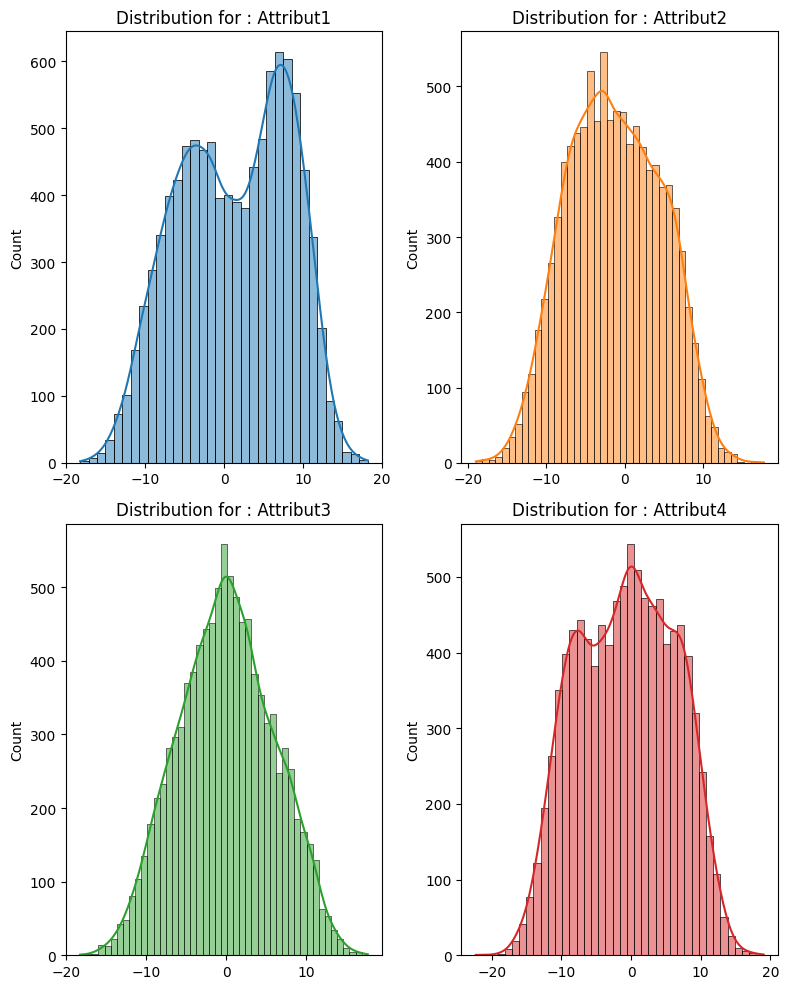

In [13]:
# Auto bins
get_distributions(X, features, 2, 2)

Visualize with wider bins

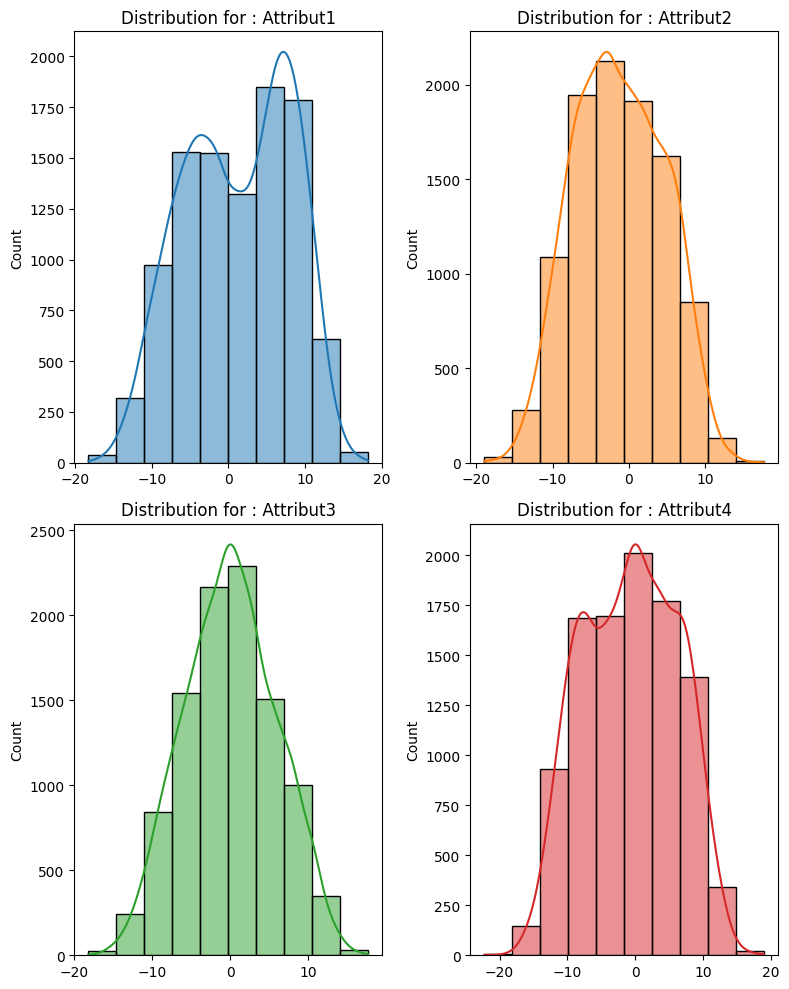

In [14]:
get_distributions(X, features, 2, 2, bins=int(len(X)/1000))


**Att2, Att3 seem normally distributed, while Att4 might be as well but kurtosis is different. Att1 has bimodal distribution**

In [15]:
def check_normality(df, features):
    for feat in features:
        norm = shapiro(df[feat])
        if norm.pvalue < 0.05:
            print(f"{feat} is not normally distributed since pval={norm.pvalue} < 0.05")
        else:
            print(f"{feat} follows a normal distribution (null hypothesis)")

In [16]:
check_normality(df, features)

Attribut1 is not normally distributed since pval=1.0769216919075154e-39 < 0.05
Attribut2 is not normally distributed since pval=2.298475423334648e-24 < 0.05
Attribut3 is not normally distributed since pval=2.6933894364485934e-15 < 0.05
Attribut4 is not normally distributed since pval=3.646550984195728e-32 < 0.05


/home/local/USHERBROOKE/lals2906/programming/py_env/py3_ds/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


**We cannot check Normality with a standard Shap-Wilk test since we have a large amount of objects and thus hypothesis testing will always yields a rejection of the null hypothesis since not a lot of points are needed to deviate**

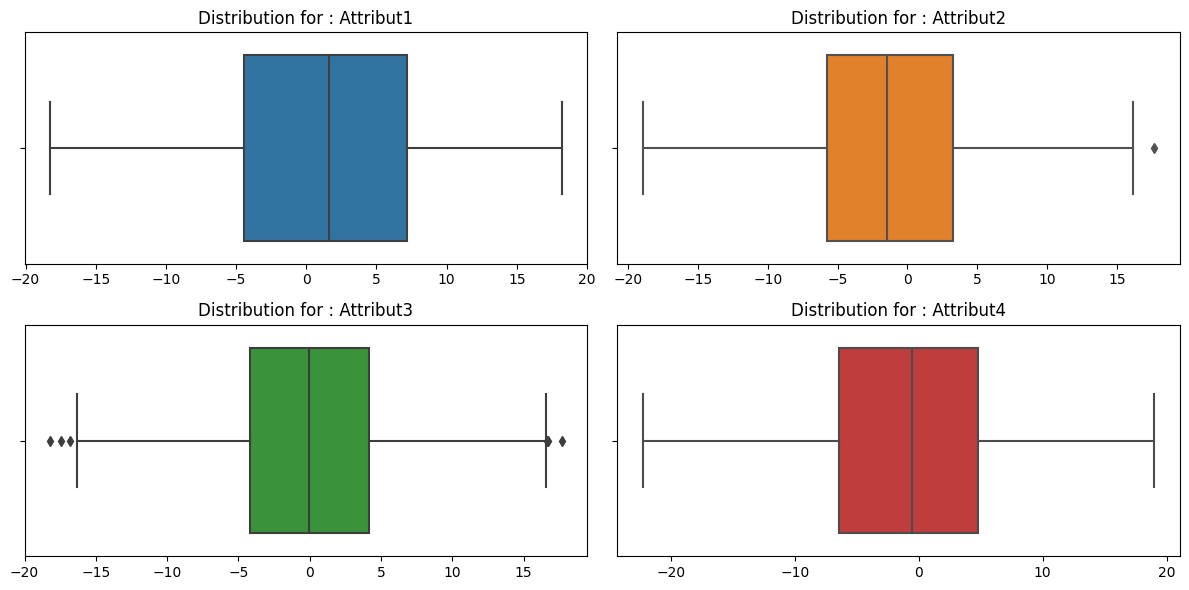

In [17]:
def get_boxplots(df, features, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols, figsize=(12,6))
    axes = axes.ravel()

    for i, feat in enumerate(features):
        plot = sns.boxplot(data=df, x=feat, ax=axes[i], color=sns.color_palette()[i])
        plot.set(title=f"Distribution for : {feat}")
        plot.set(xlabel="")

    fig.tight_layout()
get_boxplots(df, features, 2, 2)

Let's check those outliers for Att2 and Att3

In [18]:
def get_outliers(df, feat):
    iqr_feat = iqr(df[feat])
    
    # Get quartiles and outlier limits
    q1, q2, q3, = df.quantile(np.linspace(0.25, 0.75, num=3))[feat].astype(int)
    lower_lim = q1 - 1.5*iqr_feat
    upper_lim = q3 + 1.5*iqr_feat

    # print outliers
    if len(df[df[feat] > upper_lim][feat].values) > 0 or len(df[df[feat] < lower_lim][feat].values) > 0:
        upper_lim_outliers = df[df[feat] > upper_lim][feat]
        lower_lim_outliers = df[df[feat] < lower_lim][feat]
        print(f"{len(lower_lim_outliers)+len(upper_lim_outliers)} outliers for {feat}:\n")
        print(upper_lim_outliers)
        print(lower_lim_outliers)
        print("\n")
for i in range(len(features)):
    get_outliers(df, features[i])

3 outliers for Attribut2:

6000    17.688653
Name: Attribut2, dtype: float64
5488   -18.962684
6463   -18.815461
Name: Attribut2, dtype: float64


7 outliers for Attribut3:

551     16.660461
3392    16.697278
5363    17.670892
6725    16.534034
Name: Attribut3, dtype: float64
4620   -18.208884
5501   -17.444804
5887   -16.820523
Name: Attribut3, dtype: float64




**All features are uncorrelated with each other**

In [19]:
X.corr()[abs(X.corr()) > 0.5]

,Attribut1,Attribut2,Attribut3,Attribut4
Attribut1,1.0,NaN,NaN,NaN
Attribut2,NaN,1.0,NaN,NaN
Attribut3,NaN,NaN,1.0,NaN
Attribut4,NaN,NaN,NaN,1.0


#### Distributions for classes or class balancing?

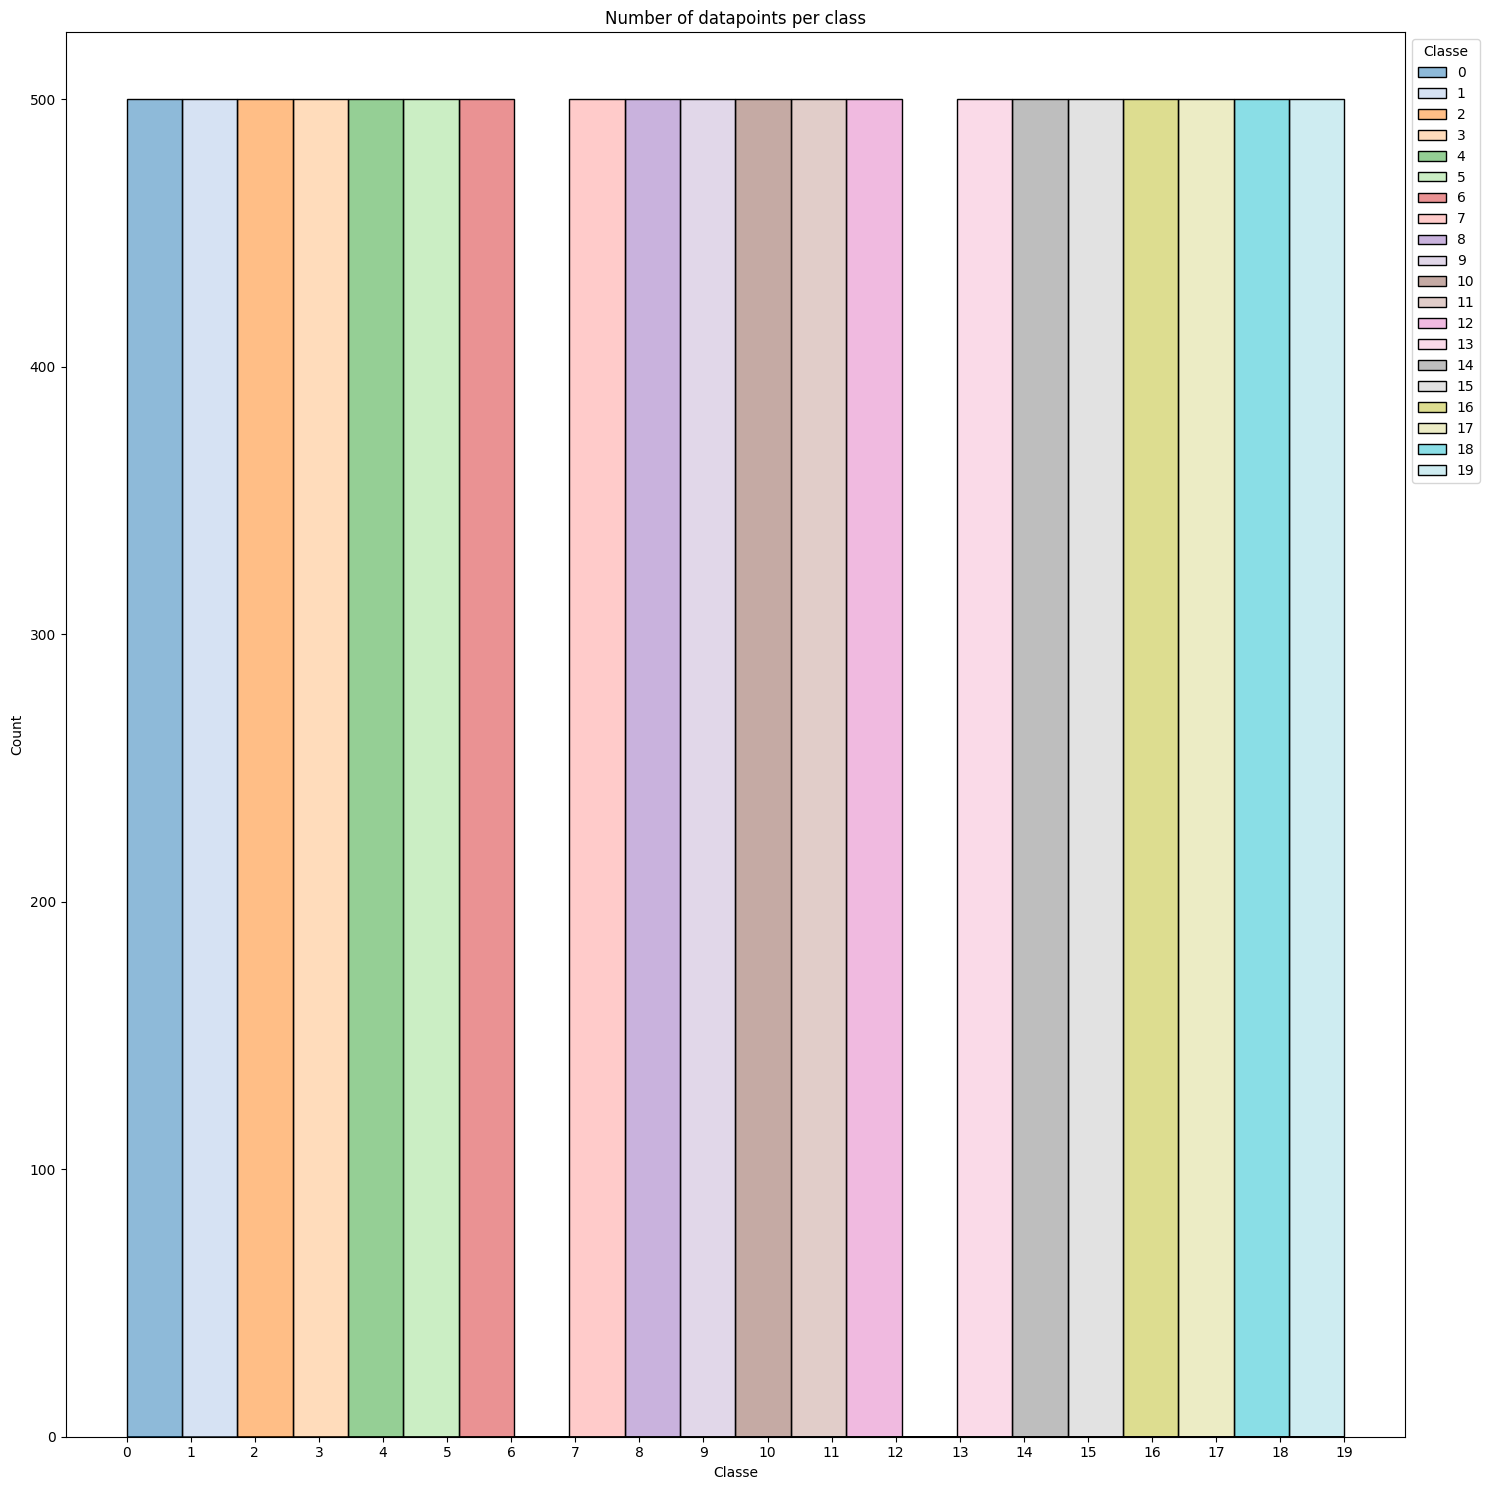

In [20]:
fig, ax = plt.subplots(figsize=(15,15))
g = sns.histplot(df, x=class_name, hue=class_name, palette="tab20", legend="full")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))
g.set_xticks(range(len(df[class_name].unique())))
g.set_xticklabels(list(range(0, 20)))
ax.set_title("Number of datapoints per class")
fig.tight_layout()

Yes classes are balanced

#### Correlations of features with classes

In [21]:
print(f"We have {len(df[class_name].unique())} classes")

We have 20 classes


In [22]:
df.corr()

,Attribut1,Attribut2,Attribut3,Attribut4,Classe
Attribut1,1.000000,-0.083767,0.004046,0.178558,0.364229
Attribut2,-0.083767,1.000000,0.028610,0.262127,-0.158917
Attribut3,0.004046,0.028610,1.000000,0.048547,0.006596
Attribut4,0.178558,0.262127,0.048547,1.000000,0.065589
Classe,0.364229,-0.158917,0.006596,0.065589,1.000000


<Axes: >

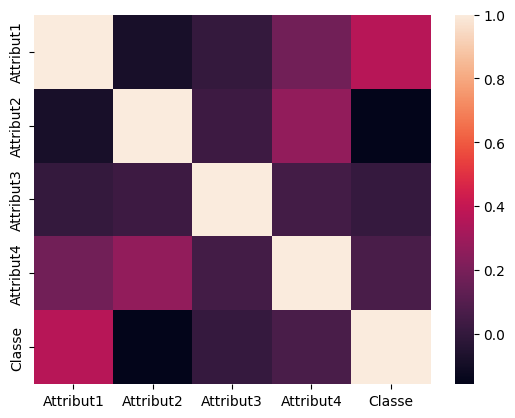

In [23]:
# Pairplot for features
sns.heatmap(df.corr())



No correlation between class and features with this model. Since we have a lot of objects (10k) and a lot of classes (20)

**Let's look at data with dimensionality reduction applied to see if our classes our well separated**

<Axes: xlabel='pc1', ylabel='pc2'>

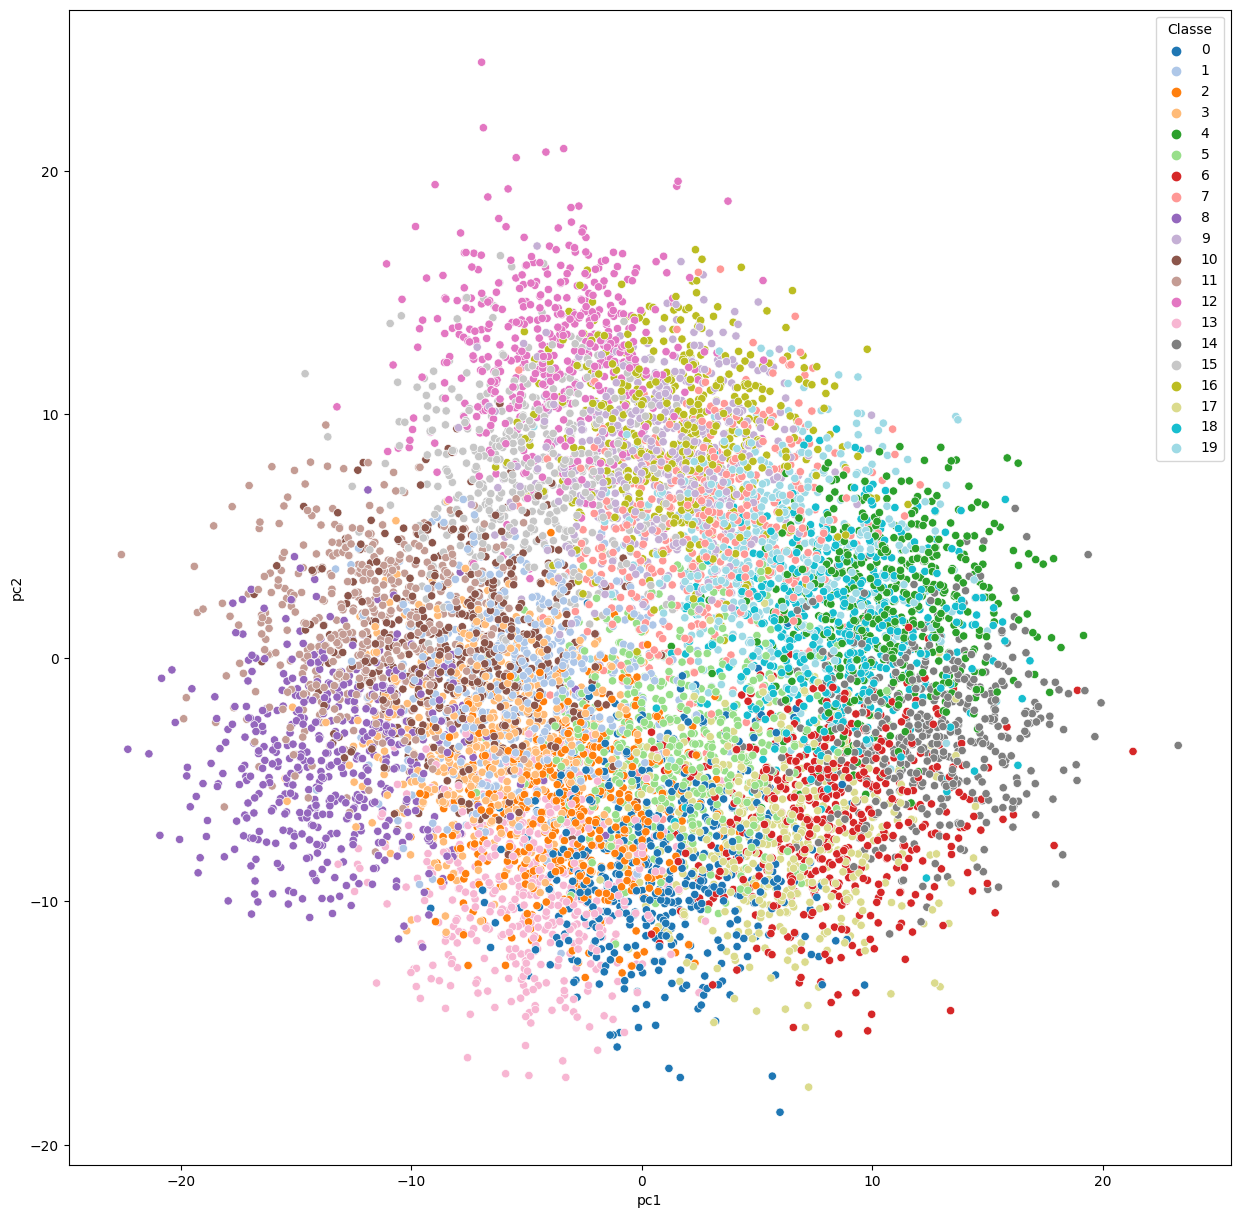

In [24]:
# Fit and save as df
pca = PCA(n_components=2).fit(X)
X_2d = pd.DataFrame(pca.transform(X), columns=["pc1", "pc2"])
# Plot the PCA
fig = plt.subplots(figsize=(15,15))
sns.scatterplot(X_2d, x="pc1", y="pc2", hue=y, legend="full", palette="tab20")


OK lot's of overlap, maybe the local similarities are strong and the differences not so large. Let's look at t-SNE representation

<Axes: xlabel='dim1', ylabel='dim2'>

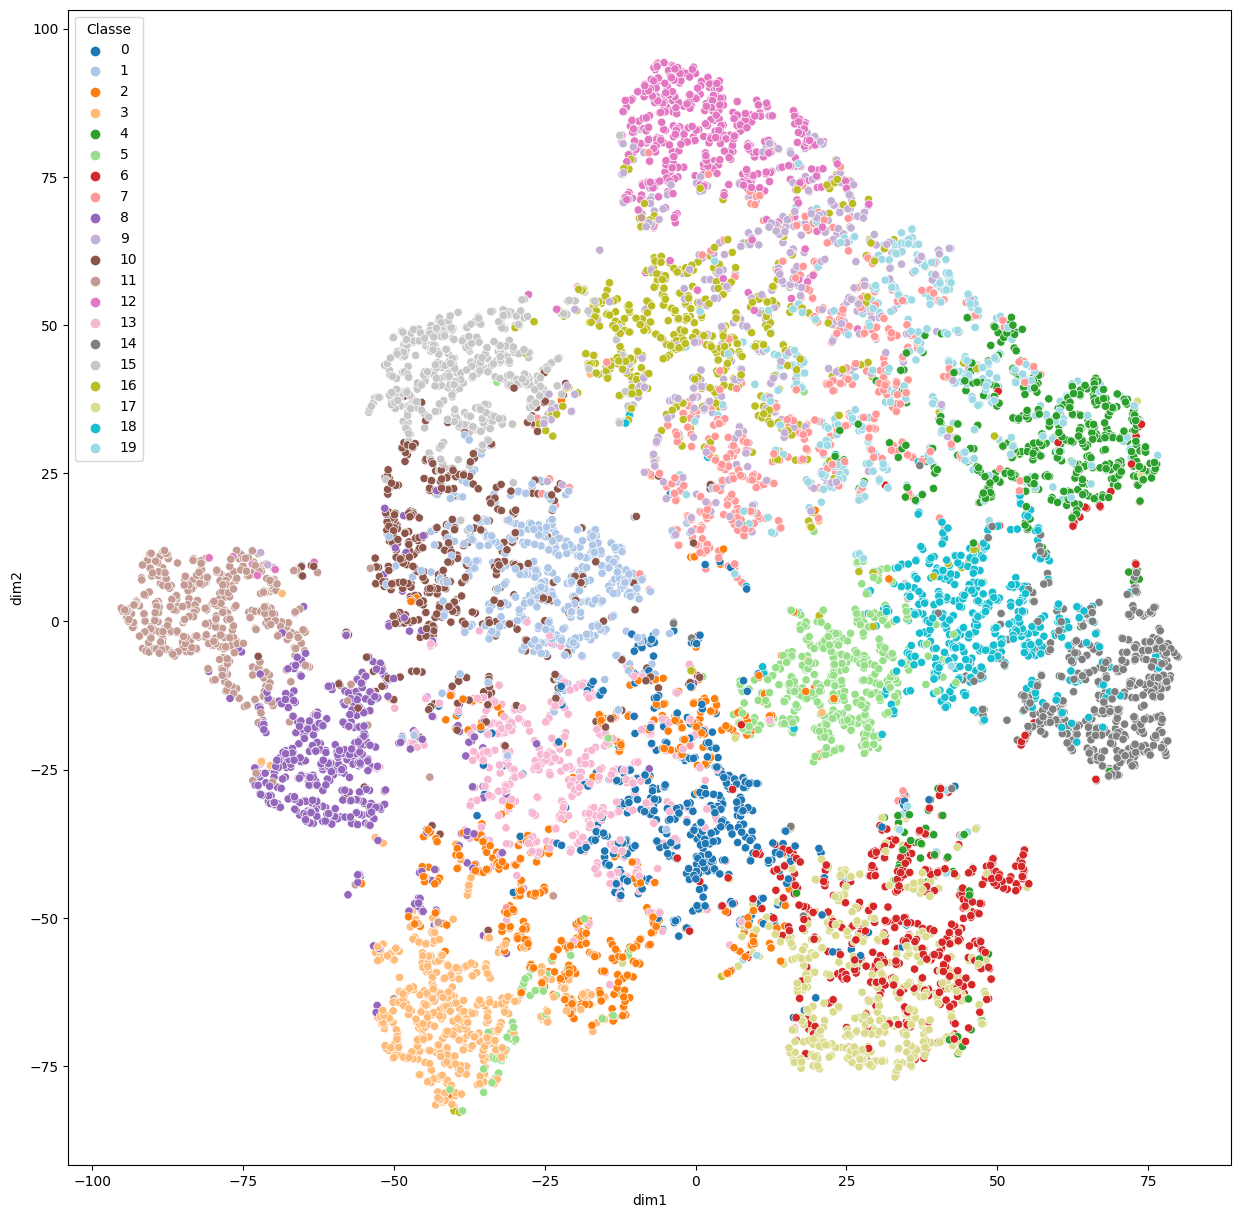

In [25]:
tsne = TSNE(n_components=2).fit_transform(X)
X_tsne = pd.DataFrame(tsne, columns=["dim1", "dim2"])
# Plot the reduced data
fig = plt.subplots(figsize=(15,15))
sns.scatterplot(X_tsne, x="dim1", y="dim2", hue=y, legend="full", palette="tab20")

**Much better representation, we see that some classes are clearly clustered and well separated from other (homogenous) and other will be more heterogenous**

## 1. Score and hyperparameter optimization functions implementation

#### Helper functions

train_test_split and standard scaling

In [26]:
# Return multiple train_test_splits with different test_sizes
def multiple_tts(X, y, test_sizes: list):
    X_train, X_test, y_train, y_test = {}, {}, {}, {}
    for test_size in test_sizes:
        X_train[test_size], X_test[test_size], y_train[test_size], y_test[test_size] = train_test_split(X, y, test_size=test_size, random_state=0)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = multiple_tts(X, y, test_sizes=[0.1, 0.2, 0.3])
X_train[0.1]

,Attribut1,Attribut2,Attribut3,Attribut4
1554,7.637775,-3.418114,-4.963948,1.612481
2087,-3.144264,8.618204,-5.091692,5.127572
5470,-5.491494,-4.156375,3.952644,3.005412
2363,6.550642,-1.157854,-5.250464,5.007091
7570,-0.377753,0.783914,3.676936,-6.834488
...,...,...,...,...
9225,11.464851,-7.300147,4.954286,-2.654950
4859,-6.418174,4.438924,0.244552,7.514159
3264,-3.680281,-2.170209,3.063411,-12.806189
9845,-2.842872,-0.673961,8.554157,9.504225


In [27]:
def apply_scaling(X_train: dict, X_test: dict, scaler_model):
    """Iterate through train/test dict, fit the model for each train/test partition and return the scaled data
    """
    X_train_scaled = {}
    X_test_scaled = {}
    # Iterate through each test_size
    for test_size in X_train.keys():
        # Fit the scaler on the given test_size
        fitted_scaler = scaler_model.fit(X_train[test_size])
        # Transform train and test sets from fitted scaler
        X_train_scaled[test_size] = pd.DataFrame(fitted_scaler.transform(X_train[test_size]), columns=[f"{feat}_scaled" for feat in features])
        X_test_scaled[test_size] = pd.DataFrame(fitted_scaler.transform(X_test[test_size]), columns=[f"{feat}_scaled" for feat in features])

    return X_train_scaled, X_test_scaled

X_train_scaled, X_test_scaled = apply_scaling(X_train, X_test, MinMaxScaler())
    

#### a) model_score implementation that returns the score (accuracy) of a given classification model (X data, y classes) with a k=5 Cross-Fold validation

In [28]:
def model_score(X, y, classifier, params: dict, show_full_score=False, show_mean_std=True):
    """
    implementation that returns the score (accuracy) of a given classification model (X data, y classes)
    with a k=5 Cross-Fold validation

    Args:
        X (pd.DataFrame or np.array): Dataset with final attributes values to train and test the model
        y (pd.Series or np.array): Known classes for all objects
        classifier: sklearn instanciated class object from a given classifier (i.e. KNeighbordsClassifier)
        params (dict): dictionary with the a given set of hyperparameters (i.e. params = {"n_neighbors": 10, "p": 5})
        show_full_score (bool): Show all scores from each fold if True
        show_mean_std (bool): Show mean and standard deviation aggregation from each fold if True
    
    Returns:
        mean_test_score (float): Mean accuracy from 5-fold CV evaluation of the classifier for predictions accross the whole dataset
    """
    # Params key and range
    n_range = range(1, 21)
    p_range = range(1, 11)
    params_keys = ["p", "n_neighbors"]

    # Validate arguments    
    if [key for key in params.keys()][0] not in params_keys or [key for key in params.keys()][1] not in params_keys:
        raise KeyError(f"params keys must be {params_keys}")
    if params["n_neighbors"] not in n_range:
        raise ValueError(f"n_neighbors must be within {n_range}")
    if params["p"] not in p_range:
        raise ValueError(f"p must be within {p_range}")

    # Partition in stratified k=5 folds (balanced class = regular KFold) with pre-shuffle but random seed set to compare accross hyperparams runs
    skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

    # Modify the objects attributes with the given parameters
    clf = classifier
    clf.set_params(n_neighbors=params["n_neighbors"], p=params["p"])

    # Get all scores from cv=5
    scoring = "accuracy"
    cv_scores = cross_val_score(classifier, X, y, cv=skf, scoring=scoring)
    # Calculate mean and std
    mean_test_score = np.mean(cv_scores)
    
    if show_full_score:
        print(f'Test scores: {cv_scores}')
    if show_mean_std:
        print(f"{mean_test_score=:.4f}, std_test_score={np.std(cv_scores):.4f} with n_neighbors={params['n_neighbors']} and p={params['p']}")
    return mean_test_score

model_score(X, y, KNeighborsClassifier(), {"n_neighbors": 5, "p": 5}, show_full_score=True)

Test scores: [0.6975 0.683  0.694  0.6935 0.7105]
mean_test_score=0.6957, std_test_score=0.0088 with n_neighbors=5 and p=5


0.6957

#### b) bruteforce_optimisation implementation that returns the parameters (n_neighbors and p) from bruteforce search with the overall best test score

In [29]:
def bruteforce_optim(classifier, params_grid: dict, X, y):
    """Bruteforce optimisation that fits the model with every hyperparameter combinations and returns the params dict with the max test score

    Args:
        classifier (): sklearn instanciated class object from a given classifier (i.e. KNeighbordsClassifier)
        params_grid (dict): dictionary with the a given set of range of hyperparameters (i.e. params = {"n_neighbors": range(1,11), "p": range(1,6)})
        X (pd.DataFrame or np.array): Training set with final attributes values to evaluate the hyperparameters
        y (pd.Series or np.array): Known classes for all objects in the training set
    Returns:
        best_params (dict): parameters with best accuracy score
    """

    # Fit model on each hyperparameter combinations and evaluate the score
    params = {}
    best_score = None
    best_params = {}
    for n in params_grid["n_neighbors"]:
        for p in params_grid["p"]:
            params["n_neighbors"] = n
            params["p"] = p
            score = model_score(X, y, classifier, params)
            # Keep first iteration as best
            if best_score is None:
                best_score = score
                for key in params:
                    best_params[key] = params[key]
            # Keep the best scores and parameters
            if score > best_score:
                best_score = score
                for key in params:
                    best_params[key] = params[key]
    print(f"Bruteforce results: best accuracy score={best_score:.4f} achieved with n_neighbors={best_params['n_neighbors']} and p={best_params['p']}")
    return best_params

            
bruteforce_optim(KNeighborsClassifier(), params_grid={"n_neighbors" : range(3, 5), "p" : range(5, 10)}, X=X, y=y)    

mean_test_score=0.6710, std_test_score=0.0098 with n_neighbors=3 and p=5
mean_test_score=0.6713, std_test_score=0.0113 with n_neighbors=3 and p=6
mean_test_score=0.6715, std_test_score=0.0112 with n_neighbors=3 and p=7
mean_test_score=0.6713, std_test_score=0.0109 with n_neighbors=3 and p=8
mean_test_score=0.6705, std_test_score=0.0106 with n_neighbors=3 and p=9
mean_test_score=0.6861, std_test_score=0.0095 with n_neighbors=4 and p=5
mean_test_score=0.6858, std_test_score=0.0077 with n_neighbors=4 and p=6
mean_test_score=0.6848, std_test_score=0.0081 with n_neighbors=4 and p=7
mean_test_score=0.6855, std_test_score=0.0077 with n_neighbors=4 and p=8
mean_test_score=0.6866, std_test_score=0.0071 with n_neighbors=4 and p=9
Bruteforce results: best accuracy score=0.6866 achieved with n_neighbors=4 and p=9


{'n_neighbors': 4, 'p': 9}

#### c) randomize_optimisation implementation that returns the parameters (n_neighbors and p) from only a proprtion of the available search space (percent_sample)


In [37]:
def randomize_optimisation(classifier, params_grid: dict, X, y, sample_percent: int):
    """Random optimization that fits the model with a subset of random hyperparameter combinations (based on sample_percent) and returns the params dict with the max test score

    Args:
        classifier (): sklearn instanciated class object from a given classifier (i.e. KNeighbordsClassifier)
        params_grid (dict): dictionary with the a given set of range of hyperparameters (i.e. params = {"n_neighbors": range(1,11), "p": range(1,6)})
        X (pd.DataFrame or np.array): Training set with final attributes values to evaluate the hyperparameters
        y (pd.Series or np.array): Known classes for all objects in the training set
        sample_percent (int): percentage of sampled hyperparameters
    Returns:
        best_params (dict): parameters with best accuracy score
    """

    # Validate sample_percent
    if not 0 < sample_percent < 100:
        raise ValueError("sample_percent must be within 1 and 99")
    
    # Select a random hyperparameters combinations based on sample_percent
    sample_percent = sample_percent/100
    rand_n = np.random.choice(
        params_grid["n_neighbors"],
        round(len(params_grid["n_neighbors"]) * sample_percent),
        replace=False
        )
    rand_p = np.random.choice(
        params_grid["p"],
        round(len(params_grid["p"]) * sample_percent),
        replace=False)
    print(f"Calculating accuracy scores using {sample_percent*100}% of original search space from randomly selected n_neighbors={rand_n} and p={rand_p}...\n")
    
    # Fit model on each hyperparameter combinations and evaluate the score
    best_score = None
    params = {}
    best_params = {}
    
    for n in rand_n:
        for p in rand_p:
            params["n_neighbors"] = n
            params["p"] = p
            score = model_score(X, y, classifier, params)

            # Keep first iteration as best
            if best_score is None:
                best_score = score
                for key in params:
                    best_params[key] = params[key]

            # Keep the best scores and parameters
            if score > best_score:
                best_score = score
                for key in params:
                    best_params[key] = params[key]

    print(f"Randomize_optim results: best accuracy score={best_score:.4f} achieved with n_neighbors={best_params['n_neighbors']} and p={best_params['p']}")
    return best_params

randomize_optimisation(KNeighborsClassifier(), params_grid={"n_neighbors" : range(5, 11), "p" : range(5, 11)}, X=X, y=y, sample_percent=50)   

Calculating accuracy scores using 50.0% of original search space from randomly selected n_neighbors=[10  6  9] and p=[8 6 7]...

mean_test_score=0.7136, std_test_score=0.0051 with n_neighbors=10 and p=8
mean_test_score=0.7145, std_test_score=0.0044 with n_neighbors=10 and p=6
mean_test_score=0.7128, std_test_score=0.0045 with n_neighbors=10 and p=7
mean_test_score=0.7006, std_test_score=0.0029 with n_neighbors=6 and p=8
mean_test_score=0.7007, std_test_score=0.0041 with n_neighbors=6 and p=6
mean_test_score=0.7006, std_test_score=0.0034 with n_neighbors=6 and p=7
mean_test_score=0.7117, std_test_score=0.0053 with n_neighbors=9 and p=8
mean_test_score=0.7125, std_test_score=0.0055 with n_neighbors=9 and p=6
mean_test_score=0.7112, std_test_score=0.0055 with n_neighbors=9 and p=7
Randomize_optim results: best accuracy score=0.7145 achieved with n_neighbors=10 and p=6


{'n_neighbors': 10, 'p': 6}

#### d) halving_optimisation implementation that uses an incremental data partitionning and gradual hyperparameter selection to return a single set of hyperparameters to keep

In [31]:
def halving_optimisation(classifier, params_grid: dict, X, y, n_splitting: int, show_iterations=True):
    """Halving optimisation that gradually reduces the size of hyperparameter search space while increasing the amount of data used to generate scores.

    Args:
        classifier (): sklearn instanciated class object from a given classifier (i.e. KNeighbordsClassifier)
        params_grid (dict): dictionary with the a given set of range of hyperparameters (i.e. params = {"n_neighbors": range(1,11), "p": range(1,6)})
        X (pd.DataFrame or np.array): Training set with final attributes values to evaluate the hyperparameters
        y (pd.Series or np.array): Known classes for all objects in the training set
        n_splitting (int): number of splits to partition the data and hyperparams search space
    
    Returns:
        best_params (dict): parameters with best accuracy score
    """
    # Initialize best_params_indexes outside splitting
    # best_params_indexes = []
    
    # Get the complete search space size
    all_n_neighbors = list(params_grid["n_neighbors"])
    all_p = list(params_grid["p"])
    params_combinations = [(n, p) for n in all_n_neighbors for p in all_p]
    params_combinations = [(i, comb) for i, comb in enumerate(params_combinations)]
    total_space_size = len(params_combinations)
    
    # Loop through each splits
    for split in range(n_splitting):
        
        # Size of parameter space and data
        current_param_space_size = int(total_space_size * (n_splitting - split) / n_splitting)
        current_sample_space_size = int(len(X) * (split + 1) / n_splitting)

        # Bypass first split + select the parameters and data to calculate the score
        if split == 0:
            current_params = params_combinations[:current_param_space_size]
            
        else:
            # Get the best parameters taking into account the current search space
            best_params_indexes = [index for index in sorted_scores_index.keys()][:current_param_space_size]
            current_params = [params_combinations[i] for i in range(len(params_combinations)) if i in best_params_indexes]
            # print(best_params_indexes)
            # print(current_params)
        
        X_sample = X[:current_sample_space_size]
        y_sample = y[:current_sample_space_size]

        # Initialize variables and reset best_params_indexes
        scores_index = {}
        params = {}
        best_params_indexes = []

        scores_index = {}
        sorted_scores_index = {}

        # Loop through each combination and calculate the score
        for combination in current_params:
            params["n_neighbors"] = combination[1][0]
            params["p"] = combination[1][1]

            
            # Calculate score
            score = model_score(X_sample, y_sample, classifier, params, show_mean_std=False)
            
            # Save score with param_combination index and reverse sort
            scores_index[combination[0]] = score

        # Sort param indexes by best scoring accuracy
        sorted_scores_index = {k: v for k, v in sorted(scores_index.items(), key=lambda item: item[1], reverse=True)}

        # Retrieve top5 for current split
        top5_accuracies = [val for val in sorted_scores_index.values()][:5]
        top5_combinations_index = [index for index in sorted_scores_index.keys()][:5]
        top5_combinations = [comb for i, comb in current_params if i in top5_combinations_index]

        top5_n = [comb[0] for comb in top5_combinations]
        top5_p = [comb[1] for comb in top5_combinations]
        
        if show_iterations:
            print(f"""
                Top accuracy={top5_accuracies} for n_neighbors={top5_n} and p={top5_p}
                at search_space of size={current_param_space_size} and sample_size={current_sample_space_size}
                and split iteration #{split+1}
                """
            )

    # Save best combination of hyperparameter from last split
    best_combination = top5_combinations[0]
    top_accuracy = top5_accuracies[0]
    best_params = {"n_neighbors" : top5_n[0], "p" : top5_p[0]}
    print(f"""
        Best combination of hyperparameters (original index, (n_neigh, p)) {best_combination}
        Accuracy={top_accuracy:.4f} with n_neighbors={best_params["n_neighbors"]} and p={best_params["p"]}
        at the last split with n_splitting={split +1} and last search space of size={current_param_space_size} and whole sample size of {current_sample_space_size}
        """
    )
    
    return best_params


halving_optimisation(
    KNeighborsClassifier(),
    params_grid={"n_neighbors" : range(5, 11), "p" : range(5, 11)},
    X=X,
    y=y,
    n_splitting=5,
    show_iterations=True
)


                Top accuracy=[0.7135, 0.7135, 0.7135, 0.7130000000000001, 0.712] for n_neighbors=[10, 10, 10, 10, 10] and p=[5, 7, 8, 9, 10]
                at search_space of size=36 and sample_size=2000
                and split iteration #1
                

                Top accuracy=[0.7085000000000001, 0.70825, 0.70825, 0.70775, 0.7072499999999999] for n_neighbors=[9, 10, 10, 10, 10] and p=[5, 5, 8, 9, 10]
                at search_space of size=28 and sample_size=4000
                and split iteration #2
                

                Top accuracy=[0.7070000000000001, 0.7058333333333333, 0.7055, 0.7055, 0.7050000000000001] for n_neighbors=[9, 9, 10, 10, 10] and p=[5, 6, 7, 8, 10]
                at search_space of size=21 and sample_size=6000
                and split iteration #3
                

                Top accuracy=[0.717875, 0.71625, 0.716, 0.7152499999999999, 0.715125] for n_neighbors=[10, 10, 10, 10, 10] and p=[5, 6, 7, 8, 9]
                at search_spac

{'n_neighbors': 10, 'p': 5}

#### e) bayesian optimisation implementation that uses an approximation function that to estimate a score by sampling.

In [147]:
def bayesian_optimisation(classifier, params_grid: dict, X, y, s_size: int, n_iter: int):
    """_summary_

    Args:
        classifier (): sklearn instanciated class object from a given classifier (i.e. KNeighbordsClassifier)
        params_grid (dict): dictionary with the a given set of range of hyperparameters (i.e. params = {"n_neighbors": range(1,11), "p": range(1,6)})
        X (pd.DataFrame or np.array): Training set with final attributes values to evaluate the hyperparameters
        y (pd.Series or np.array): Known classes for all objects in the training set
        s_size (int): Size of sampled hyperparameters at each iteration (i.e. s_size = 5)
        n_iter (int): Number of iterations to perform (i.e. n_iter = 100)
    
    Returns:
        best_params (dict): 
    """
    # Get the complete search space size
    all_n_neighbors = list(params_grid["n_neighbors"])
    all_p = list(params_grid["p"])
    params_combinations = [(n, p) for n in all_n_neighbors for p in all_p]

    # Generate a list of dictionaries + dataframe with all searchspace
    all_params_list = []
    
    for comb in params_combinations:
        params = {}
        params["n_neighbors"] = comb[0]
        params["p"] = comb[1]
        all_params_list.append(params)
    
    all_params_df = pd.DataFrame(all_params_list)
    
    # Select random hyperparameters combinations (E) based on s_size
    rand_comb_E = random.sample(params_combinations, k=s_size)
    
    # Initialize list containers
    E_params_list = []
    scores = []

    # Generate model_score input and calculate scores for each combination
    print(f"Generating scores with {s_size} randomly selected combinations...")
    for comb in rand_comb_E:
        params = {}
        params["n_neighbors"] = comb[0]
        params["p"] = comb[1]
        E_params_list.append(params)
        
        score = model_score(X, y, classifier, params, show_mean_std=False)
        scores.append(score)

    # Convert params_list to df
    E_params_df = pd.DataFrame(E_params_list)
    
    # Fit the Gaussian Process Regressor to the initial sample
    print(f"Fitting the GPR before the {n_iter} iterations")
    gpr = GaussianProcessRegressor()
    gpr.fit(E_params_df, scores)
    print(f"Scores from the initial {s_size} random hyperparam combinations : {scores}\n")
    
    # Iterate and predict scores for all hyperparams with prob func
    for i in range(n_iter):
        mu, sig = gpr.predict(all_params_df, return_std=True)
        
        # Get maximum average of pred scores
        max_pred_avg = max(mu)
        
        # Sample s_size params randomly
        new_params = random.sample(all_params_list, k=s_size)
        new_params_df = pd.DataFrame(new_params)
        
        # Predict scores for subset of random hyperparams of s_size with current prob func
        mu_new, sig_new = gpr.predict(new_params_df, return_std=True)

        # Transform the predictions into a probability distribution using the cdf
        probabilities = norm.cdf((mu_new - max_pred_avg) / (sig_new + 1e-6))

        # Choose the hyperparameter setting with maximum probability
        max_param_index = np.argmax(probabilities)
        max_param = new_params[max_param_index]
        max_param_df = pd.DataFrame([max_param])
        
        # Append max_param to E, calculate score and refit model
        E_params_df = pd.concat([E_params_df, max_param_df], ignore_index=True)
        
        print(f"Calculating score for max param with approximation function from iteration {i + 1}")
        max_param_score = model_score(X, y, classifier, max_param, show_mean_std=False)
        print(f"max param score at current iteration = {max_param_score}\n")
        scores.append(max_param_score)
        
        gpr.fit(E_params_df, scores)

    # Return best parameters from E after n_iter iterations
    best_param_index = np.argmax(scores)
    best_param = E_params_df.iloc[best_param_index].to_dict()
    print(f"Best hyperparameters combination {best_param} with score of {scores[best_param_index]:.6f}")

    return best_param
    
bayesian_optimisation(
    KNeighborsClassifier(),
    {"n_neighbors" : range(1, 6), "p" : range (6, 11)},
    X, y,
    s_size=5,
    n_iter=50
)

Generating scores with 5 randomly selected combinations...
Fitting the GPR before the 50 iterations
Scores from the initial 5 random hyperparam combinations : [0.6713000000000001, 0.6858, 0.6713000000000001, 0.6302, 0.6308999999999999]

Calculating score for max param with approximation function from iteration 1
max param score at current iteration = 0.6927

Calculating score for max param with approximation function from iteration 2
max param score at current iteration = 0.6309

Calculating score for max param with approximation function from iteration 3
max param score at current iteration = 0.6866000000000001

Calculating score for max param with approximation function from iteration 4
max param score at current iteration = 0.6308

Calculating score for max param with approximation function from iteration 5
max param score at current iteration = 0.6715

Calculating score for max param with approximation function from iteration 6
max param score at current iteration = 0.6858000000000

{'n_neighbors': 5, 'p': 6}

## 2. Optimisation function comparisons

#### a) Test different data partitionning strategies with each function

In [33]:
# if not 0 < test_size < 1:
    #     raise ValueError("test_size must be a float greater than 0 and less than 1")